angles:  (11138, 4)
angles:  (11138, 4)


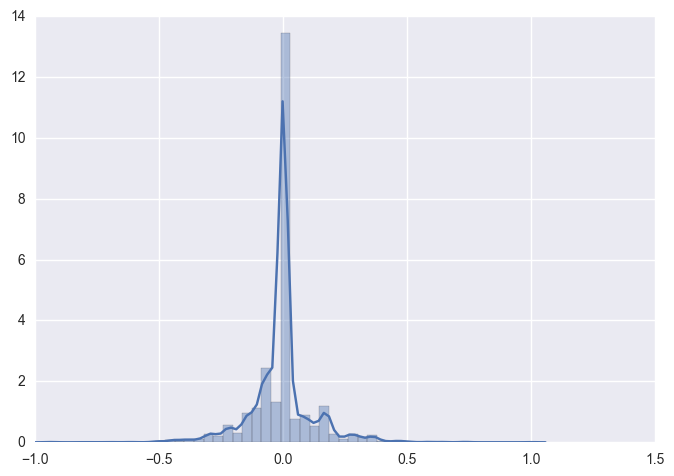

In [33]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import os
import seaborn as sns
%matplotlib inline

data = "./data/"
log = "driving_log.csv"


data = pd.read_csv(data + log)
angles = data[["center", "left", "right", "steering"]]
print("angles: ", angles.shape)

print("angles: ", angles.shape)

sns.set(color_codes=True)       
sns.distplot(angles.steering.values)


In [21]:
angles_0 = angles[angles.steering == 0]
angles_1 = angles[angles.steering != 0]
print(angles_0.shape, angles_1.shape)

(6041, 4) (6122, 4)


In [22]:
angles_0_sampled = angles_0.sample(frac=0.2, random_state=0)
angles_1_sampled = angles_1.sample(frac=1, random_state=0)

(7330, 4)


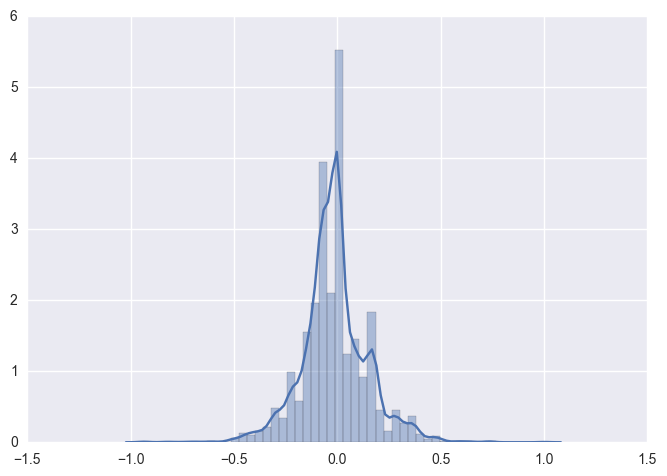

In [23]:
angles_sampled = pd.concat([angles_0_sampled, angles_1_sampled])
print(angles_sampled.shape)
sns.distplot(angles_sampled.steering.values)

In [24]:
file_list_center = angles_sampled[["center"]].values
angle_list_center = angles_sampled[["steering"]].values

file_list_left = angles_sampled[["left"]].values
angle_list_left = angle_list_center + 0.25

file_list_right = angles_sampled[["right"]].values
angle_list_right = angle_list_center - 0.25

file_list = np.concatenate((file_list_center, file_list_left, file_list_right))
angle_list = np.concatenate((angle_list_center, angle_list_left, angle_list_right))

file_list = np.squeeze(file_list)
angle_list = np.squeeze(angle_list)
print(file_list.shape, angle_list.shape)

(21990,) (21990,)


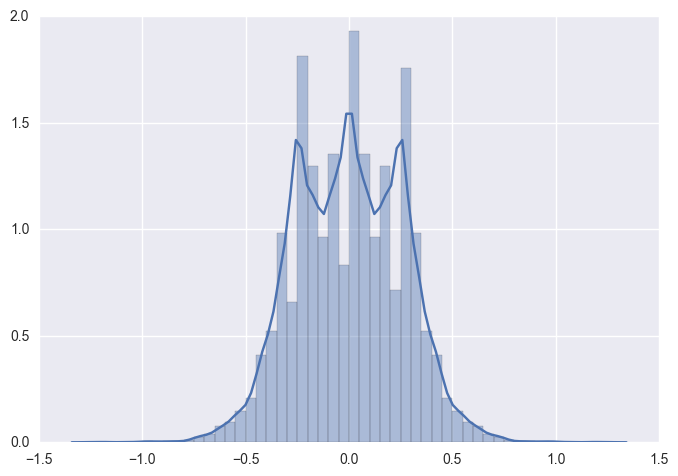

In [25]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train = []
X_train_flip = [] 
angle_list_flip = -1 * angle_list
for filename in file_list:
    if(filename[0] == ' '):
        filename = filename[1:]
    imgBGR = cv2.imread(filename) 
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    imgRGB = imgRGB[60:130, 0:320]
    X_train.append(imgRGB)
    X_train_flip.append(np.fliplr(imgRGB))

X_train = np.concatenate((X_train, X_train_flip))
angle_list = np.concatenate((angle_list, angle_list_flip))

X_train, angle_list = shuffle(X_train, angle_list, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, angle_list, test_size=.2, random_state=0)
sns.distplot(angle_list)

In [26]:
X_train.shape
y_train.shape

(35184,)

In [27]:
np.save("./X_train", X_train)
np.save("./y_train", y_train)
np.save("./X_val", X_val)
np.save("./y_val", y_val)

# **Behavioral Cloning** 

---

**Behavrioal Cloning Project**

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report


[//]: # (Image References)

[image1]: ./examples/placeholder.png "Model Visualization"
[image2]: ./examples/placeholder.png "Grayscaling"
[image3]: ./examples/placeholder_small.png "Recovery Image"
[image4]: ./examples/placeholder_small.png "Recovery Image"
[image5]: ./examples/placeholder_small.png "Recovery Image"
[image6]: ./examples/placeholder_small.png "Normal Image"
[image7]: ./examples/placeholder_small.png "Flipped Image"

---
### Files Submitted & Code Quality

#### 1. Submission includes all required files and can be used to run the simulator in autonomous mode

My project includes the following files:
* preprocess.ipynb preprocess the data in junyper notebook
* model.py containing the script to create and train the model
* drive.py for driving the car in autonomous mode
* model.h5 containing the weight of trained network 
* model.json containing the model
* writeup_report.md summarizing the results

#### 2. Submssion includes functional code
Using the Udacity provided simulator and my drive.py file, the car can be driven autonomously around the track by executing 
```sh
python drive.py
```

#### 3. Submssion code is usable and readable

The model.py file contains the code for training and saving the convolution neural network. The file shows the pipeline I used for training and validating the model, and it contains comments to explain how the code works.

### Model Architecture and Training Strategy

#### 1. An appropriate model arcthiecture has been employed

I'm using Nvidia model which introduced in this paper:(http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf). 

The first layer is a normalization layer, which normalize image values between -0.5 to 0.5.

Following are 5 convolution layers, a dropout layer, and 4 dense layers.

The model includes RELU activation function in each layer to introduce nonlinearity.

#### 2. Attempts to reduce overfitting in the model

The model contains a dropout layer in order to reduce overfitting. 

The model was trained and validated on different data sets to ensure that the model was not overfitting. The model was tested by running it through the simulator and ensuring that the vehicle could stay on the track.

#### 3. Model parameter tuning

The model used an adam optimizer, so the learning rate was not tuned manually.

#### 4. Appropriate training data

I'm using Udacity data. I also used PS4 controller run 2 laps to generate additional data, incluidng recovery data, but in the final model I just used Udacity data and the result is good.

### Model Architecture and Training Strategy

#### 1. Solution Design Approach

The approach I used can be described in two steps: 

1.Data exploration and preprocessing 
2.Model design and tuning

First I did some data exploration then some preprocess, since the zero angle data is dominating, I screen out 80% zero angle data, and for image from left camera I add +0.25 to the angle, -0.25 to the angle for right camera image. I crop the sky and the hood of the car out, since they are irrelavent information. And I mirrored all image to balance left turn and right turn.

Then I tried feed the data to the model, first I tried with the model from comma.ai, but the car keep turning left, then I add 2 more dense layers, but wasn't able to improve the model. Then I tried to use Udacity data only, this time the car was able to drive within the lane until the first turn. Then I switched to Nvidia model which contains more convolution layers, and the car was able to drive in the lane.

#### 2. Final Model Architecture

The final model architecture (model.py lines 18-24) consisted of a convolution neural network with the following layers and layer sizes ...

Here is a visualization of the architecture (note: visualizing the architecture is optional according to the project rubric)

![alt text][image1]

#### 3. Creation of the Training Set & Training Process

To capture good driving behavior, I first recorded two laps on track one using center lane driving. Here is an example image of center lane driving:

![alt text][image2]

I then recorded the vehicle recovering from the left side and right sides of the road back to center so that the vehicle would learn to .... These images show what a recovery looks like starting from ... :

![alt text][image3]
![alt text][image4]
![alt text][image5]

Then I repeated this process on track two in order to get more data points.

To augment the data sat, I also flipped images and angles thinking that this would ... For example, here is an image that has then been flipped:

![alt text][image6]
![alt text][image7]

Etc ....

After the collection process, I had X number of data points. I then preprocessed this data by ...


I finally randomly shuffled the data set and put Y% of the data into a validation set. 

I used this training data for training the model. The validation set helped determine if the model was over or under fitting. The ideal number of epochs was Z as evidenced by ... I used an adam optimizer so that manually training the learning rate wasn't necessary.